In [1]:
!pip install datasets

In [2]:
!pip install transformers

In [6]:
import os
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

C:\Users\danie\Documents\COGS402\cogs402longformer\src
C:\Users\danie\Documents\COGS402\cogs402longformer


In [1]:
import datasets 

In [2]:
#load dataset
dataset=datasets.load_dataset('hyperpartisan_news_detection', 'bypublisher')


Reusing dataset hyperpartisan_news_detection (C:\Users\danie\.cache\huggingface\datasets\hyperpartisan_news_detection\bypublisher\1.0.0\7f4215b0474950ddf516e806400ab81d098b3da3b3a919a13cd1a4cf2c677012)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
#import huggingface models
from transformers import LongformerForSequenceClassification, LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

#base model for training 
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096",num_labels=2)

#importing local checkpoint
model2 = LongformerForSequenceClassification.from_pretrained("models/longformer-finetuned/checkpoint-10000",num_labels=2)

#import same version from hub
model3 = LongformerForSequenceClassification.from_pretrained("danielhou13/longformer-finetuned-news-cogs402",num_labels=2)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weig

In [8]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
    validation: Dataset({
        features: ['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'],
        num_rows: 600000
    })
})


In [9]:
#seperate the two datasets
train_ds = dataset["train"]
eval_ds = dataset["validation"]

In [10]:
print(type(train_ds))

<class 'datasets.arrow_dataset.Dataset'>


In [11]:
#convert hyperpartisan to correct format (from true/false to 1/0)
labels = map(int, train_ds['hyperpartisan'])
labels = list(labels)

labels2 = map(int, eval_ds['hyperpartisan'])
labels2 = list(labels2)

In [12]:
#add the columns to the dataset
train_ds = train_ds.add_column("labels", labels)
eval_ds = eval_ds.add_column("labels", labels2)

In [13]:
#trainer API auto uses dynamic padding... supposedly
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [15]:
## Take subset of data
train_size = 20000
val_size = 5000
import numpy as np

train_indices = np.random.randint(0, len(train_ds), train_size)
val_indices = np.random.randint(0, len(eval_ds), val_size)
train_ds = train_ds.select(train_indices)
val_ds = eval_ds.select(val_indices)

#tokenize the data
train_dataset = train_ds.map(tokenize, load_from_cache_file=False)
val_dataset = val_ds.map(tokenize, load_from_cache_file=False)


0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [16]:
#remove unnessesary columns and convert needed ones to torch format
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

train_dataset = train_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
val_dataset = val_dataset.remove_columns(['text', 'title', 'hyperpartisan', 'url', 'published_at', 'bias'])
print(train_dataset)


Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 20000
})


In [17]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model3.to(device)
device

device(type='cuda')

In [30]:
#create checkpointing folder if doesn't exist
if not os.path.exists("models"):
    os.mkdir("models")

In [31]:
from transformers import Trainer, TrainingArguments

batch_size = 1
gradient_acc = 4
logging_steps = (len(train_dataset) // batch_size) //gradient_acc
model_name = f"longformer-finetuned"
training_args = TrainingArguments(output_dir=f"models/{model_name}",
                                  num_train_epochs = 2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  fp16=True,
                                  gradient_accumulation_steps=gradient_acc,
                                  gradient_checkpointing=True,
                                  save_strategy = "epoch")

In [32]:
print(logging_steps)

5000


In [33]:
#create the metrics we want to find out, can import othe things like precision, recall if needed
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [34]:
trainer = Trainer(
    model=model3,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator = data_collator
)


In [23]:
trainer.train()

C:\Users\danie\miniconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.304600,0.198418,0.958200,0.958201
2,0.144900,0.197256,0.965600,0.965598


TrainOutput(global_step=10000, training_loss=0.22472103271484375, metrics={'train_runtime': 16132.7768, 'train_samples_per_second': 2.479, 'train_steps_per_second': 0.62, 'total_flos': 2.937687111518215e+16, 'train_loss': 0.22472103271484375, 'epoch': 2.0})

In [35]:
preds_output = trainer.predict(val_dataset)

In [36]:
preds_output.metrics

{'test_loss': 0.2201802283525467,
 'test_accuracy': 0.96,
 'test_f1': 0.9600002560040961,
 'test_runtime': 465.8458,
 'test_samples_per_second': 10.733,
 'test_steps_per_second': 10.733}

In [37]:
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(val_dataset["labels"])

In [38]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true, y_preds, target_names=["false", "true"]
    )
)

              precision    recall  f1-score   support

       false       0.96      0.96      0.96      2486
        true       0.96      0.96      0.96      2514

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



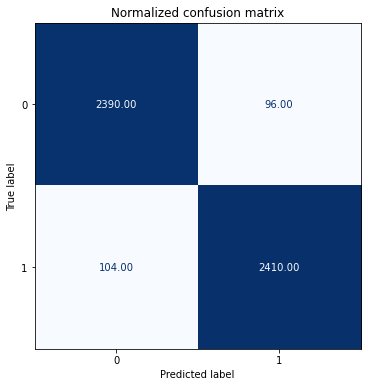

(5000,)
(5000,)


In [39]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["false", "true"])
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_true, labels=[0,1])
print(y_true.shape)
print(y_preds.shape)

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
# # upload model to huggingface for storage
# # replace danielhou13 with personal user
# model3.push_to_hub("danielhou13/longformer-finetuned-news-cogs402)